Alex Campili

Intro to Deep Learning - Final Project

Presentation: https://www.youtube.com/watch?v=WNq0oa_M2X8

## SPY Volatility Forecasting using LSTM Neural Networks

In [3]:
## import required modules
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from sklearn.preprocessing import scale
import keras
import itertools
import math
from sklearn.metrics import mean_squared_error
!pip install arch
from arch import arch_model

We will be using 20 years of daily data for SPY - the SPDR S&P 500 Index ETF pulled from Yahoo! Finance (https://finance.yahoo.com/quote/SPY?p=SPY). We first import the data and calculate metrics including daily returns and 1-month annualized volatility

In [4]:
## ----- initial data processing -----
## import data 

spy_data = pd.read_csv('SPY.csv')
spy_data = spy_data[['Date','Close']]
## calculate daily returns
spy_data['DoD_Ret'] = spy_data['Close'].pct_change()
## calculate 1-month annualized volatility
spy_data['1M_Vol'] = spy_data['DoD_Ret'].rolling(21).std()*(252**0.5)
spy_data = spy_data.dropna()
display(spy_data.head(5))

,Date,Close,DoD_Ret,1M_Vol
21,2000-09-07,150.843750,0.008567,0.112694
22,2000-09-08,149.812500,-0.006837,0.111215
23,2000-09-11,149.593750,-0.001460,0.109643
24,2000-09-12,148.500000,-0.007311,0.112332
25,2000-09-13,148.890625,0.002630,0.103449


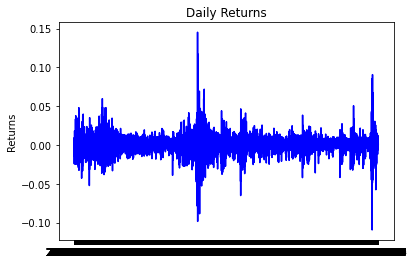

In [37]:
## visual inspection of returns
plt.plot(spy_data['Date'], spy_data['DoD_Ret'], 'b', label = "Daily Returns")
plt.ylabel("Returns")
plt.title("Daily Returns")
plt.show()

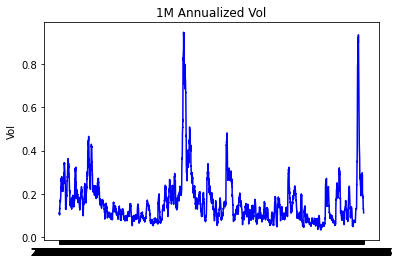

In [38]:
## visual inspection of vol
plt.plot(spy_data['Date'], spy_data['1M_Vol'], 'b', label = "Vol")
plt.ylabel("Vol")
plt.title("1M Annualized Vol")
plt.show()

Next, we set up our data so that it is in the correct format to feed to our LSTM. This involves both splitting the data into training and testing sets (using an unshuffled 80/20 split) as well as creating feature sets of 3-months of prior vol data and corresponding lables

In [5]:
## ----- setting up data for LSTM -----
## ! code inspired from class section notebook ! 
X = spy_data['1M_Vol']

## set timesteps equal to 3 months of data
n_timesteps = 21*3

## create feature sets of 3 months prior data and corresponding output at 
## each time i in the entire dataset
features_set = []
labels = []
for i in range(n_timesteps, X.shape[0]):
    features_set.append(X[i-n_timesteps:i])
    labels.append(X[i])
    
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set,(features_set.shape[0], features_set.shape[1], 1))

## split into train and test sets
n = features_set.shape[0]
n_train = int(n * 0.80)
n_test = n - n_train

features_set_train, features_set_test =  features_set[0:n_train,:,:], features_set[n_train:n,:,:]
labels_train, labels_test =  labels[0:n_train], labels[n_train:n]

display(features_set_train[0].shape)
display(labels_train[0].shape)


(63, 1)

()

We can now set up a framework for tuning hyperparameters in our model. We first set up an LSTM with ReLU activation function, an intermediate dropout layer, and a 1D dense output layer with linear activation function. The function below is used so that a user can vary inputs for different hyperparameters. We will use it in a loop over an exhaustive combination of hyperparameters for their respective values considered. The function outputs a dictionary that stores the input parameters and the test RMSE. Note that the architecture of the LSTM, including activation functions, as well as the choice of optimizer and loss function, cannot be changed under this framework. 

In [22]:
## defining a function that runs our neural network with hyperparameters given 
## as a user input. We will use this function in a loop to consider multiple
## parameter combinations

def run_LSTM(dropout_rate, learning_rate, n_nodes, n_epochs, batch_size):
    ## set up LSTM architecture
    model = models.Sequential()
    model.add(layers.LSTM(n_nodes, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='linear')) 

    ## compile model with adam optimizer and mse loss function
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse')
    
    ## fit the model
    history = model.fit(features_set_train, labels_train,
                epochs=n_epochs,
                batch_size=batch_size,
                validation_data=(features_set_test, labels_test))
    history = history.history
    
    ## store predicted values on the test set
    preds = model.predict(features_set_test)
    
    ## create dictionary output storing parameters and test RMSE
    output = {}
    output['params'] = [dropout_rate, learning_rate, n_nodes, n_epochs, batch_size]
    output['test_score'] = math.sqrt(mean_squared_error(labels_test, preds))
    
    return(output)

Using the framework above, we can test multiple combination of hyperparameters:

In [ ]:
## set values we will test in our framework
dropout_rates = [0.2, 0.4]
learning_rates = [0.1, 0.01, 0.001]
n_nodes = [2, 4]
n_epochs = [25]
batch_size = [32, 64]

## get all possible combinations
total = [dropout_rates, learning_rates, n_nodes, n_epochs, batch_size]
param_combns = list(itertools.product(*total))

display(param_combns)

[(0.2, 0.1, 2, 25, 32),
 (0.2, 0.1, 2, 25, 64),
 (0.2, 0.1, 4, 25, 32),
 (0.2, 0.1, 4, 25, 64),
 (0.2, 0.01, 2, 25, 32),
 (0.2, 0.01, 2, 25, 64),
 (0.2, 0.01, 4, 25, 32),
 (0.2, 0.01, 4, 25, 64),
 (0.2, 0.001, 2, 25, 32),
 (0.2, 0.001, 2, 25, 64),
 (0.2, 0.001, 4, 25, 32),
 (0.2, 0.001, 4, 25, 64),
 (0.4, 0.1, 2, 25, 32),
 (0.4, 0.1, 2, 25, 64),
 (0.4, 0.1, 4, 25, 32),
 (0.4, 0.1, 4, 25, 64),
 (0.4, 0.01, 2, 25, 32),
 (0.4, 0.01, 2, 25, 64),
 (0.4, 0.01, 4, 25, 32),
 (0.4, 0.01, 4, 25, 64),
 (0.4, 0.001, 2, 25, 32),
 (0.4, 0.001, 2, 25, 64),
 (0.4, 0.001, 4, 25, 32),
 (0.4, 0.001, 4, 25, 64)]

Below we will run all possible combinations from above

***NOTE***: This chunk takes a very long time to run. I would personally recommend refraining from running it, unless the user would like to test other hyperparameter values from those included above. In subsequent code, I will provide a final model, in which the hyperparameters can be adjusted. If you wish to try toggling one of the parameters, I would recommend simply changing one of them and running the single model. 

In [23]:
## ----- TUNING HYPERPARAMETERS -----
n_features=1
## create array to store test RMSE
scores = np.repeat(0.0, len(param_combns))
i = 0
## loop through all possible parameter combinations, fit model and store RMSE
for params in param_combns:
    out = run_LSTM(*params)
    scores[i] = out['test_score']
    i = i + 1



Epoch 1/25
124/124 [==============================] - 12s 95ms/step - loss: 0.0141 - val_loss: 0.0219
Epoch 2/25
124/124 [==============================] - 11s 89ms/step - loss: 0.0119 - val_loss: 0.0204
Epoch 3/25
124/124 [==============================] - 11s 89ms/step - loss: 0.0120 - val_loss: 0.0191
Epoch 4/25
124/124 [==============================] - 11s 91ms/step - loss: 0.0120 - val_loss: 0.0188
Epoch 5/25
124/124 [==============================] - 11s 90ms/step - loss: 0.0121 - val_loss: 0.0195
Epoch 6/25
124/124 [==============================] - 11s 92ms/step - loss: 0.0121 - val_loss: 0.0203
Epoch 7/25
124/124 [==============================] - 11s 89ms/step - loss: 0.0120 - val_loss: 0.0216
Epoch 8/25
124/124 [==============================] - 11s 88ms/step - loss: 0.0123 - val_loss: 0.0218
Epoch 9/25
124/124 [==============================] - 11s 91ms/step - loss: 0.0127 - val_loss: 0.0192
Epoch 10/25
124/124 [==============================] - 11s 90ms/step - loss: 0.011

We can then find our 'optimal' parameters by minimizing test RMSE over all of the models considered

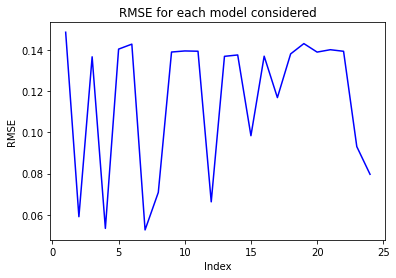

In [24]:
## visual inspection of test RMSEs
index = range(1, len(param_combns)+1)

## plot validation and training loss
plt.plot(index, scores, 'b', label="Model Score")
plt.title('RMSE for each model considered')
plt.xlabel('Index')
plt.ylabel('RMSE')
    
plt.show()

In [25]:
## output the parameters that minimize test RMSE

min_index =  np.where(scores == scores.min())
params_df = pd.DataFrame({"Parameter":['dropout_rate', 'learning_rate', 'n_nodes', 'n_epochs', 'batch_size'],
                          "Value":param_combns[min_index[0][0]]})
display(params_df)

,Parameter,Value
0,dropout_rate,0.20
1,learning_rate,0.01
2,n_nodes,4.00
3,n_epochs,25.00
4,batch_size,32.00


Now, using these 'optimal' parameters, we can fit our final model. 

In [33]:
## ----- FITTING THE FINAL MODEL -----
## define global variables to use in final function
dropout_rate = 0.2
learning_rate = 0.01
n_nodes = 4
n_epochs = 25
batch_size = 32

## set up LSTM architecture
model = models.Sequential()
model.add(layers.LSTM(n_nodes, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(1, activation='linear')) 

print(model.summary())

## compile and fit model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mse')
history = model.fit(features_set_train, labels_train,
                epochs=n_epochs,
                batch_size=batch_size,
                validation_data=(features_set_test, labels_test))

history = history.history



Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 4)                 96        
_________________________________________________________________
dropout_54 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
124/124 [==============================] - 11s 90ms/step - loss: 0.0112 - val_loss: 0.0163
Epoch 2/25
124/124 [==============================] - 11s 88ms/step - loss: 0.0078 - val_loss: 0.0125
Epoch 3/25
124/124 [==============================] - 11s 86ms/step - loss: 0.0065 - val_loss: 0.0130
Epoch 4/25
124/124 [==============================] - 11s 88ms/step - loss

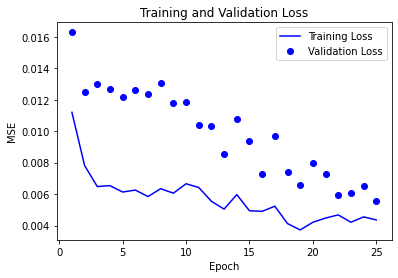

In [34]:
## plot validation and training loss
epochs = range(1, n_epochs+1)
plt.plot(epochs, history['loss'], 'b', label="Training Loss")
plt.plot(epochs, history['val_loss'], 'bo', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
    
plt.show()



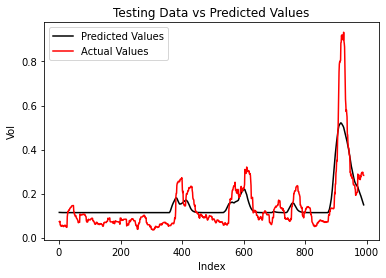

In [35]:
## plot predictions vs actual data for test set
predictions = model.predict(features_set_test)
index = range(1, len(predictions)+1)
plt.plot(index, predictions, 'b', color = 'black', label="Predicted Values")
plt.plot(index, labels_test, 'b', color = 'red', label="Actual Values")
plt.title('Testing Data vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Vol')
plt.legend()
    
plt.show()



In [36]:
## output RMSE
rmse_final = math.sqrt(mean_squared_error(labels_test, predictions))
display(rmse_final)

0.07448273726701704

It would appear that our model performs reasonably well on the test set. To get a sense for general model improvement with respect to classical models for volatility forecasting, we can also compare results with the standard GARCH(1,1) method:

In [32]:
## ----- Fit GARCH Model for Comparison -----
X = spy_data['DoD_Ret'] * 100
## first, split training and testing data
X_train, X_test = X[0:n_train], X[n_train:n]


## next fit the model using parameters p=1, q=1
garch_model = arch_model(X_train, vol = 'Garch', p=1, q=1, dist='Normal')
garch_out = garch_model.fit()
display(garch_out.summary())
## get model predictions for the horizon equivalent to the test set
garch_pred = garch_out.forecast(horizon=n_test)
garch_predictions = 0.1 * garch_pred.variance.values[-1, :]

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5602.180614785801
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5598.255334814363
Iteration:      3,   Func. Count:     24,   Neg. LLF: 5593.058943697331
Iteration:      4,   Func. Count:     33,   Neg. LLF: 5592.902271549755
Iteration:      5,   Func. Count:     40,   Neg. LLF: 5589.547322161251
Iteration:      6,   Func. Count:     47,   Neg. LLF: 5588.794112441943
Iteration:      7,   Func. Count:     54,   Neg. LLF: 5587.496255183709
Iteration:      8,   Func. Count:     61,   Neg. LLF: 5587.076007985761
Iteration:      9,   Func. Count:     67,   Neg. LLF: 5587.016404980962
Iteration:     10,   Func. Count:     73,   Neg. LLF: 5586.95180575042
Iteration:     11,   Func. Count:     79,   Neg. LLF: 5586.951568388268
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5586.951567762466
            Iterations: 11
            Function evaluations: 80
            Gradient evaluations: 11

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                DoD_Ret   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -5586.95
Distribution:                  Normal   AIC:                           11181.9
Method:            Maximum Likelihood   BIC:                           11207.0
                                        No. Observations:                 3958
Date:                Sun, Aug 09 2020   Df Residuals:                     3954
Time:                        20:57:47   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0532  1.329e-02      4.007  6.153e-05 [2.720e-02,7.928e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0195  5.255e-03      3.719  2.004e-04 [9.242e-03,2.984e-02]
alpha[1]       0.0992  1.187e-02      8.361  6.238e-17   [7.596e-02,  0.122]
beta[1]        0.8857  1.236e-02     71.634      0.000     [  0.862,  0.910]
============================================================================

Covariance estimator: robust
"""

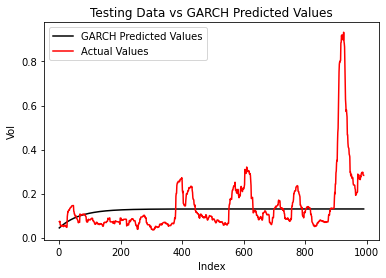

In [33]:
## plot predicted vs actual
index=range(1, n_test+1)
plt.plot(index, garch_predictions, 'b', color = 'black', label="GARCH Predicted Values")
plt.plot(index, labels_test, 'b', color = 'red', label="Actual Values")
plt.title('Testing Data vs GARCH Predicted Values')
plt.xlabel('Index')
plt.ylabel('Vol')
plt.legend()
    
plt.show()




In [39]:
## output test RMSE
rmse_garch = math.sqrt(mean_squared_error(labels_test, garch_predictions))
display(rmse_garch)

0.13601015567152452

We can see that the test RMSE for the GARCH model is much higher than that for our LSTM. There are certainly more sophisticated methods for fitting GARCH models, but in general our LSTM seems to be a good improvement, and is still a reasonably interpretable model that can be easily implemented. 